# Load the libraries

In [4]:
library(data.table);
library(ggplot2);
library(repr)
library(reshape2)
##library(gplots)
library(pheatmap)
library(cowplot)
library(RColorBrewer)
library(sva)
library(ggExtra)
library("e1071")
library('glmnet')

source("helper_functions.R")

In [5]:
options(repr.plot.width = 3, repr.plot.height = 3, repr.plot.res=80)
name <- "CLUESImmVar_processed.V5.1";

# Load the necessary input

## Load the covariates from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [6]:
cm_covs <- fread("v5.expr/v5.full.cM.immvar21.covs.txt");
colnames(cm_covs) <- sapply(colnames(cm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})
covs_gene_names <- cm_covs$V1;
cm_covs <- as.matrix(cm_covs[,-1]);

th_covs <- as.matrix(fread("v5.expr/v5.full.Th.immvar21.covs.txt")[,-1]);
colnames(th_covs) <- sapply(colnames(th_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

tc_covs <- as.matrix(fread("v5.expr/v5.full.Tc.immvar21.covs.txt")[,-1]);
colnames(tc_covs) <- sapply(colnames(tc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

ncm_covs <- as.matrix(fread("v5.expr/v5.full.ncM.immvar21.covs.txt")[,-1]);
colnames(ncm_covs) <- sapply(colnames(ncm_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

b_covs <- as.matrix(fread("v5.expr/v5.full.B.immvar21.covs.txt")[,-1]);
colnames(b_covs) <- sapply(colnames(b_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

nk_covs <- as.matrix(fread("v5.expr/v5.full.NK.immvar21.covs.txt")[,-1]);
colnames(nk_covs) <- sapply(colnames(nk_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

dc_covs <- as.matrix(fread("v5.expr/v5.full.cDC.immvar21.covs.txt")[,-1]);
colnames(dc_covs) <- sapply(colnames(dc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

pbmc_covs <- as.matrix(fread("v5.expr/v5.full.PBMC.immvar21.covs.txt")[,-1]);
colnames(pbmc_covs) <- sapply(colnames(pbmc_covs), function(x) {strsplit(x,"_")[[1]][[1]]})

rownames(pbmc_covs) <- rownames(cm_covs) <- rownames(th_covs) <- rownames(tc_covs) <- rownames(ncm_covs) <- rownames(b_covs) <- rownames(nk_covs) <-rownames(dc_covs) <- covs_gene_names;


## Load the processed expression data from ```/ye/yelabstore2/10x.lupus/eqtls/demux.v2```

In [7]:
cm_expr <- fread("v5.expr/v5.full.cM.blind.expr.txt");
colnames(cm_expr) <- sapply(colnames(cm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})
expr_gene_names <- cm_expr$V1;
cm_expr <- as.matrix(cm_expr[,-1]);

th_expr <- as.matrix(fread("v5.expr/v5.full.Th.blind.expr.txt")[,-1]);
colnames(th_expr) <- sapply(colnames(cm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

tc_expr <- as.matrix(fread("v5.expr/v5.full.Tc.blind.expr.txt")[,-1]);
colnames(tc_expr) <- sapply(colnames(tc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

ncm_expr <- as.matrix(fread("v5.expr/v5.full.ncM.blind.expr.txt")[,-1]);
colnames(ncm_expr) <- sapply(colnames(ncm_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

b_expr <- as.matrix(fread("v5.expr/v5.full.B.blind.expr.txt")[,-1]);
colnames(b_expr) <- sapply(colnames(b_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

nk_expr <- as.matrix(fread("v5.expr/v5.full.NK.blind.expr.txt")[,-1]);
colnames(nk_expr) <- sapply(colnames(nk_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

dc_expr <- as.matrix(fread("v5.expr/v5.full.cDC.blind.expr.txt")[,-1]);
colnames(dc_expr) <- sapply(colnames(dc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

pbmc_expr <- as.matrix(fread("v5.expr/v5.full.PBMC.blind.expr.txt")[,-1]);
colnames(pbmc_expr) <- sapply(colnames(pbmc_expr), function(x) {a <- strsplit(x,"_"); if(length(a[[1]])==3) {return(paste(a[[1]][2:3],collapse="_"))} else {return(paste(a[[1]][1:2],collapse="_"))}})

rownames(pbmc_expr) <- rownames(cm_expr) <- rownames(th_expr) <- rownames(tc_expr) <- rownames(ncm_expr) <- rownames(b_expr) <- rownames(nk_expr) <-rownames(dc_expr) <- expr_gene_names;

## do a quick filter for all zeros
any_zeros = unique(c(which(rowSums(pbmc_expr) ==0),
                     which(rowSums(cm_expr)==0),
                     which(rowSums(ncm_expr)==0),
                     which(rowSums(th_expr)==0),
                     which(rowSums(tc_expr)==0),
                     which(rowSums(b_expr)==0),
                     which(rowSums(nk_expr)==0),
                     which(rowSums(dc_expr)==0)))
pbmc_expr <- pbmc_expr[-any_zeros,];
cm_expr <- cm_expr[-any_zeros,];
ncm_expr <- ncm_expr[-any_zeros,];
th_expr <- th_expr[-any_zeros,];
tc_expr <- tc_expr[-any_zeros,];
b_expr <- b_expr[-any_zeros,];
nk_expr <- nk_expr[-any_zeros,];
dc_expr <- dc_expr[-any_zeros,];
expr_gene_names <- expr_gene_names[-any_zeros];


Warning message in fread("v5.expr/v5.full.cM.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.expr/v5.full.Th.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.expr/v5.full.Tc.blind.expr.txt"):
“Detected 206 column names but the data has 207 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames(

In [8]:
# expressed_genes <- as.matrix(fread("v5.expr/v5.full.PBMC.blind.expr.genes.txt")[,-1]);

# pbmc_expr <- pbmc_expr[expressed_genes,]
# cm_expr <- cm_expr[expressed_genes,];
# ncm_expr <- ncm_expr[expressed_genes,];
# th_expr <- th_expr[expressed_genes,];
# tc_expr <- tc_expr[expressed_genes,];
# b_expr <- b_expr[expressed_genes,];
# nk_expr <- nk_expr[expressed_genes,];
# dc_expr <- dc_expr[expressed_genes,];
# expr_gene_names <- expr_gene_names[expressed_genes];

## filter samples

In [9]:
joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")

In [10]:
## let's remove the UCSF duplicate samples for now
ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

## let's get joined_ind_pivot into the same order as pbmc_expr
joined_pivot <- joined_pivot[match(ind_cov_batch[ucsf_samples_nodups],joined_ind_cov_batch),];

## below also works but may not get exactly the same sample
# ucsf_samples <- grep("lupus",cm_covs[,"batch"]);
# ucsf_samples_nodups <- ucsf_samples[!duplicated(colnames(cm_expr)[ucsf_samples])];

cm_expr <- cm_expr[,ucsf_samples_nodups];
th_expr <- th_expr[,ucsf_samples_nodups];
tc_expr <- tc_expr[,ucsf_samples_nodups];
ncm_expr <- ncm_expr[,ucsf_samples_nodups];
b_expr <- b_expr[,ucsf_samples_nodups];
nk_expr <- nk_expr[,ucsf_samples_nodups];
dc_expr <- dc_expr[,ucsf_samples_nodups];
pbmc_expr <- pbmc_expr[,ucsf_samples_nodups];

cm_covs <- cm_covs[ucsf_samples_nodups,];
th_covs <- th_covs[ucsf_samples_nodups,];
tc_covs <- tc_covs[ucsf_samples_nodups,];
ncm_covs <- ncm_covs[ucsf_samples_nodups,];
b_covs <- b_covs[ucsf_samples_nodups,];
nk_covs <- nk_covs[ucsf_samples_nodups,];
dc_covs <- dc_covs[ucsf_samples_nodups,];
pbmc_covs <- pbmc_covs[ucsf_samples_nodups,];

sle_indices <- setdiff((1:ncol(pbmc_expr)), grep("IGTB",colnames(pbmc_expr)))
sle_colnames <- colnames(pbmc_expr)[sle_indices]

cm_sle_expr <- cm_expr[,sle_indices]
th_sle_expr <- th_expr[,sle_indices]
tc_sle_expr <- tc_expr[,sle_indices]
ncm_sle_expr <- ncm_expr[,sle_indices]
b_sle_expr <- b_expr[,sle_indices]
nk_sle_expr <- nk_expr[,sle_indices]
dc_sle_expr <- dc_expr[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]

ucsf_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("lupus",pbmc_covs[,"batch"]))
ucsf_healthy_colnames <- paste(colnames(pbmc_expr)[ucsf_healthy_indices],"_ucsf",sep="")

cm_ucsf_healthy_expr <- cm_expr[,ucsf_healthy_indices]
th_ucsf_healthy_expr <- th_expr[,ucsf_healthy_indices]
tc_ucsf_healthy_expr <- tc_expr[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr <- ncm_expr[,ucsf_healthy_indices]
b_ucsf_healthy_expr <- b_expr[,ucsf_healthy_indices]
nk_ucsf_healthy_expr <- nk_expr[,ucsf_healthy_indices]
dc_ucsf_healthy_expr <- dc_expr[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]

# colnames(cm_ucsf_healthy_expr) <- colnames(th_ucsf_healthy_expr) <- colnames(tc_ucsf_healthy_expr) <- ucsf_healthy_colnames;
# colnames(ncm_ucsf_healthy_expr) <- colnames(b_ucsf_healthy_expr) <- colnames(nk_ucsf_healthy_expr) <- ucsf_healthy_colnames;
# colnames(dc_ucsf_healthy_expr) <- colnames(pbmc_ucsf_healthy_expr) <- ucsf_healthy_colnames;

broad_healthy_indices <- intersect(grep("IGTB",colnames(pbmc_expr)), grep("immvar", pbmc_covs[,"batch"]))
broad_healthy_colnames <- paste(colnames(pbmc_expr)[broad_healthy_indices],"_broad",sep="")

cm_broad_healthy_expr <- cm_expr[,broad_healthy_indices]
th_broad_healthy_expr <- th_expr[,broad_healthy_indices]
tc_broad_healthy_expr <- tc_expr[,broad_healthy_indices]
ncm_broad_healthy_expr <- ncm_expr[,broad_healthy_indices]
b_broad_healthy_expr <- b_expr[,broad_healthy_indices]
nk_broad_healthy_expr <- nk_expr[,broad_healthy_indices]
dc_broad_healthy_expr <- dc_expr[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]



# colnames(cm_broad_healthy_expr) <- colnames(th_broad_healthy_expr) <- colnames(tc_broad_healthy_expr) <- broad_healthy_colnames;
# colnames(ncm_broad_healthy_expr) <- colnames(b_broad_healthy_expr) <- colnames(nk_broad_healthy_expr) <- broad_healthy_colnames;
# colnames(dc_broad_healthy_expr) <- colnames(pbmc_broad_healthy_expr) <- broad_healthy_colnames;


In [11]:
pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))
cm_expr_std <- t(apply(cm_expr,1,standardize))
cm_expr_std[is.na(cm_expr_std)] <- 0
th_expr_std <- t(apply(th_expr,1,standardize))
th_expr_std[is.na(th_expr_std)] <- 0
b_expr_std <- t(apply(b_expr,1,standardize))
b_expr_std[is.na(b_expr_std)] <- 0
nk_expr_std <- t(apply(nk_expr,1,standardize))
nk_expr_std[is.na(nk_expr_std)] <- 0
ncm_expr_std <- t(apply(ncm_expr,1,standardize))
ncm_expr_std[is.na(ncm_expr_std)] <- 0
tc_expr_std <- t(apply(tc_expr,1,standardize))
tc_expr_std[is.na(tc_expr_std)] <- 0
dc_expr_std <- t(apply(dc_expr,1,standardize))
dc_expr_std[is.na(dc_expr_std)] <- 0


In [12]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

# options(repr.plot.width = 4, repr.plot.height = 3)
# ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

# ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

In [13]:
# pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(pbmc_deseq_sig_genes,rownames(pbmc_expr_std))),])

# df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
#             data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
#            )
# df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

# options(repr.plot.width = 4, repr.plot.height = 3)
# ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

# ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

## Load the differentially expression results

In [14]:
pbmc_deseq <- fread("v5.deseq/v5..PBMC.deseq.txt")##as.data.frame()
th_deseq <- as.data.frame(fread("v5.deseq/v5..Th.deseq.txt"))
tc_deseq <- as.data.frame(fread("v5.deseq/v5..Tc.deseq.txt"))
cm_deseq <- as.data.frame(fread("v5.deseq/v5..cM.deseq.txt"))
ncm_deseq <- as.data.frame(fread("v5.deseq/v5..ncM.deseq.txt"))
b_deseq <- as.data.frame(fread("v5.deseq/v5..B.deseq.txt"))
nk_deseq <- as.data.frame(fread("v5.deseq/v5..NK.deseq.txt"))
dc_deseq <- as.data.frame(fread("v5.deseq/v5..cDC.deseq.txt"))

pbmc_deseq_sig <- as.data.frame(fread("v5.deseq/v5..PBMC.deseq.sig.txt",header=F))$V1
th_deseq_sig <- as.data.frame(fread("v5.deseq/v5..Th.deseq.sig.txt",header=F))$V1
tc_deseq_sig <- as.data.frame(fread("v5.deseq/v5..Tc.deseq.sig.txt",header=F))$V1
cm_deseq_sig <- as.data.frame(fread("v5.deseq/v5..cM.deseq.sig.txt",header=F))$V1
ncm_deseq_sig <- as.data.frame(fread("v5.deseq/v5..ncM.deseq.sig.txt",header=F))$V1
b_deseq_sig <- as.data.frame(fread("v5.deseq/v5..B.deseq.sig.txt",header=F))$V1
nk_deseq_sig <- as.data.frame(fread("v5.deseq/v5..NK.deseq.sig.txt",header=F))$V1
dc_deseq_sig <- as.data.frame(fread("v5.deseq/v5..cDC.deseq.sig.txt",header=F))$V1
union_deseq_sig <- unique(c(pbmc_deseq_sig, cm_deseq_sig, th_deseq_sig, 
                            tc_deseq_sig, b_deseq_sig, ncm_deseq_sig, nk_deseq_sig, dc_deseq_sig));

Warning message in fread("v5.deseq/v5..PBMC.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.deseq/v5..Th.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file.”Warning message in fread("v5.deseq/v5..Tc.deseq.txt"):
“Detected 7 column names but the data has 8 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not 

In [15]:
pbmc_deseq_sig_genes <- pbmc_deseq$V1[intersect(which(pbmc_deseq$baseMean > 25), intersect(which(abs(pbmc_deseq$log2FoldChange)>1),which(pbmc_deseq$qval < 0.01)))]
cm_deseq_sig_genes <- cm_deseq$V1[intersect(which(cm_deseq$baseMean > 25), intersect(which(abs(cm_deseq$log2FoldChange)>1),which(cm_deseq$qval < 0.01)))]
th_deseq_sig_genes <- th_deseq$V1[intersect(which(th_deseq$baseMean > 25), intersect(which(abs(th_deseq$log2FoldChange)>1),which(th_deseq$qval < 0.01)))]
tc_deseq_sig_genes <- tc_deseq$V1[intersect(which(tc_deseq$baseMean > 25), intersect(which(abs(tc_deseq$log2FoldChange)>1),which(tc_deseq$qval < 0.01)))]
b_deseq_sig_genes <- b_deseq$V1[intersect(which(b_deseq$baseMean > 25), intersect(which(abs(b_deseq$log2FoldChange)>1),which(b_deseq$qval < 0.01)))]
ncm_deseq_sig_genes <- ncm_deseq$V1[intersect(which(ncm_deseq$baseMean > 25), intersect(which(abs(ncm_deseq$log2FoldChange)>1),which(ncm_deseq$qval < 0.01)))]
nk_deseq_sig_genes <- nk_deseq$V1[intersect(which(nk_deseq$baseMean > 25), intersect(which(abs(nk_deseq$log2FoldChange)>1),which(nk_deseq$qval < 0.01)))]
dc_deseq_sig_genes <- dc_deseq$V1[intersect(which(dc_deseq$baseMean > 25), intersect(which(abs(dc_deseq$log2FoldChange)>1),which(dc_deseq$qval < 0.01)))]

union_deseq_sig_genes <- unique(c(pbmc_deseq_sig_genes, cm_deseq_sig_genes, ncm_deseq_sig_genes, dc_deseq_sig_genes, th_deseq_sig_genes, tc_deseq_sig_genes,  nk_deseq_sig_genes,b_deseq_sig_genes))
length(union_deseq_sig_genes)
length(pbmc_deseq_sig_genes)
length(intersect(pbmc_deseq_sig_genes, union_deseq_sig_genes))

deseq_sig_genes <- union_deseq_sig_genes

[1] 209

[1] 149

[1] 149

In [16]:
standardize <- function(x) {(x-mean(x))/sd(x)}

all_expr_standardize <- data.frame(pbmc=t(apply(pbmc_expr,1,standardize)),
                      cm=t(apply(cm_expr,1,standardize)),
                      ncm=t(apply(ncm_expr,1,standardize)),
                      dc=t(apply(dc_expr,1,standardize)),
                      th=t(apply(th_expr,1,standardize)),
                      tc=t(apply(tc_expr,1,standardize)),
                       nk=t(apply(nk_expr,1,standardize)),
                      b=t(apply(b_expr,1,standardize)),
                        dc=t(apply(dc_expr,1,standardize))
                      )


all_expr <- data.frame(pbmc=pbmc_expr,
                      cm=cm_expr,
                      ncm=ncm_expr,
                      dc=dc_expr,
                      th=th_expr,
                      tc=tc_expr,
                       nk=nk_expr,
                      b=b_expr
                      )

all_expr_sle <- data.frame(pbmc=pbmc_sle_expr,
                      cm=cm_sle_expr,
                      ncm=ncm_sle_expr,
                      dc=dc_sle_expr,
                      th=th_sle_expr,
                      tc=tc_sle_expr,
                       nk=nk_sle_expr,
                      b=b_sle_expr
                      )
rownames(all_expr_sle) <- rownames(all_expr)


In [17]:
set.seed(1)
kmeans_rst <- kmeans(all_expr[match(deseq_sig_genes,expr_gene_names),], 7)

cell_types <- c("PBMC","cM","ncM", "DC","Th","Tc","NK","B")
ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr))),
                           disease=factor(rep(c(rep("sle",ncol(cm_sle_expr)),
                                                rep("ucsf_ctrl",ncol(cm_ucsf_healthy_expr)),
                                                rep("broad_ctrl",ncol(cm_broad_healthy_expr))),
                                              length(cell_types))))
rownames(ct_annotation) <- colnames(all_expr);

kmeans_annotation <- data.frame(cluster=factor(kmeans_rst$cluster,levels=c("1","2","6","7","3","4","5")))
rownames(kmeans_annotation) <- deseq_sig_genes;

all_expr_sig <- all_expr[match(deseq_sig_genes,expr_gene_names),]
all_expr_sig_ordered <- all_expr[match(deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]

all_expr_standardize_sig <- all_expr_standardize[match(deseq_sig_genes,expr_gene_names),]
all_expr_standardize_sig_ordered <- all_expr_standardize[match(deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]

kmeans_ordered_annotation <- kmeans_annotation[order(kmeans_annotation$cluster),]

all_expr_sle_sig <- all_expr_sle[match(deseq_sig_genes,expr_gene_names),]
all_expr_sle_sig_ordered <- all_expr_sle[match(deseq_sig_genes,expr_gene_names),][order(kmeans_annotation$cluster),]
##kmeans_ordered_annotation <- kmeans_annotation[order(kmeans_annotation$cluster),]


##bct_annotation <- list(ct_annotation=ct_annotation)

## Load the joined table and preprocess the expression and counts data

In [18]:
# joined_pivot <- fread(paste(name,'_joined_pivot_ct_perc.txt', sep=""), sep=",")
# joined_pivot <- as.data.frame(joined_pivot);
# ## filter for ucsf healthy only
# ##joined_pivot <- joined_pivot[grep("lupus",joined_pivot$batch_cov),]

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
# ##joined_pivot$batch_cov <- as.factor(joined_pivot$batch_cov)

# ind_cov = sapply(cm_covs[,"sample"], function(x) {strsplit(as.character(x),"_")[[1]][[1]]})
# ind_cov_batch = paste(ind_cov, cm_covs[,"batch"], sep="_")
# joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")
# ucsf_samples_nodups <- na.omit(match(joined_ind_cov_batch, ind_cov_batch));

# joined_pivot_filtered <- joined_pivot[match(c(colnames(pbmc_sle_expr),colnames(pbmc_ucsf_healthy_expr),colnames(pbmc_broad_healthy_expr)),joined_ind_cov_batch),]
joined_pivot_sle <- joined_pivot[match(colnames(pbmc_sle_expr), joined_ind_cov_batch),]
joined_pivot_ucsf_healthy <- joined_pivot[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch),]
joined_pivot_broad_healthy <- joined_pivot[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch),]

## get the cell type proportions

In [19]:
cm_prop = joined_pivot$"cM";##/joined_pivot_filtered$pbmc;
th_prop = joined_pivot$"Th";##/joined_pivot_filtered$pbmc;
b_prop = joined_pivot$"B";##/joined_pivot_filtered$pbmc;
nk_prop = joined_pivot$"NK";##/joined_pivot_filtered$pbmc;
ncm_prop = joined_pivot$"ncM";#/joined_pivot_filtered$pbmc;
tc_prop = joined_pivot$"Tc";#/joined_pivot_filtered$pbmc;
dc_prop = joined_pivot$"cDC";#/joined_pivot_filtered$pbmc;

joined_ind_cov_batch = paste(joined_pivot$ind_cov, joined_pivot$batch, sep="_")

## set the NAs to 0
b_prop[which(is.na(b_prop))] <- 0;
dc_prop[which(is.na(dc_prop))] <- 0;

cm_sle_prop = cm_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
th_sle_prop = th_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
b_sle_prop = b_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
nk_sle_prop = nk_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
ncm_sle_prop = ncm_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
tc_sle_prop = tc_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
dc_sle_prop = dc_prop[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]
names(cm_sle_prop) <- names(th_sle_prop) <- names(b_sle_prop) <- names(nk_sle_prop) <- names(ncm_sle_prop) <- names(tc_sle_prop) <- names(dc_sle_prop) <- joined_ind_cov_batch[match(colnames(pbmc_sle_expr), joined_ind_cov_batch)]

cm_ucsf_healthy_prop = cm_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
th_ucsf_healthy_prop = th_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
b_ucsf_healthy_prop = b_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
nk_ucsf_healthy_prop = nk_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
ncm_ucsf_healthy_prop = ncm_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
tc_ucsf_healthy_prop = tc_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
dc_ucsf_healthy_prop = dc_prop[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]
names(cm_ucsf_healthy_prop) <- names(th_ucsf_healthy_prop) <- names(b_ucsf_healthy_prop) <- names(nk_ucsf_healthy_prop) <- names(ncm_ucsf_healthy_prop) <- names(tc_ucsf_healthy_prop) <- names(dc_ucsf_healthy_prop) <- joined_ind_cov_batch[match(colnames(pbmc_ucsf_healthy_expr), joined_ind_cov_batch)]

cm_broad_healthy_prop = cm_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
th_broad_healthy_prop = th_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
b_broad_healthy_prop = b_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
nk_broad_healthy_prop = nk_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
ncm_broad_healthy_prop = ncm_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
tc_broad_healthy_prop = tc_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
dc_broad_healthy_prop = dc_prop[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]
names(cm_broad_healthy_prop) <- names(th_broad_healthy_prop) <- names(b_broad_healthy_prop) <- names(nk_broad_healthy_prop) <- names(ncm_broad_healthy_prop) <- names(tc_broad_healthy_prop) <- names(dc_broad_healthy_prop) <- joined_ind_cov_batch[match(colnames(pbmc_broad_healthy_expr), joined_ind_cov_batch)]


In [20]:
# options(repr.plot.width = 5, repr.plot.height = 5)
# pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop))),cluster_rows=F,cluster_cols=F)
# options(repr.plot.width = 5, repr.plot.height = 5)
# pheatmap(cor(cbind(pbmc_expr_std)),cluster_rows=F,cluster_cols=F)

# Let's do some batch adjustments

## first, let's adjust cell type proportion

In [21]:

props <- as.matrix(data.frame(cM=cm_prop, Th=th_prop, B=b_prop, NK=nk_prop, ncM=ncm_prop, Tc=tc_prop, DC=dc_prop));
props_sle <- as.matrix(data.frame(cM=cm_sle_prop, Th=th_sle_prop, B=b_sle_prop, NK=nk_sle_prop, ncM=ncm_sle_prop, Tc=tc_sle_prop, DC=dc_sle_prop));
props_ucsf_healthy <- as.matrix(data.frame(cM=cm_ucsf_healthy_prop, Th=th_ucsf_healthy_prop, B=b_ucsf_healthy_prop, NK=nk_ucsf_healthy_prop, ncM=ncm_ucsf_healthy_prop, Tc=tc_ucsf_healthy_prop, DC=dc_ucsf_healthy_prop));
props_broad_healthy <- as.matrix(data.frame(cM=cm_broad_healthy_prop, Th=th_broad_healthy_prop, B=b_broad_healthy_prop, NK=nk_broad_healthy_prop, ncM=ncm_broad_healthy_prop, Tc=tc_broad_healthy_prop, DC=dc_broad_healthy_prop));

## second, let's adjust cell type specific expression

In [22]:
pbmc_mean <- t(lm(t(pbmc_expr)~1)$fitted)
cm_mean <- t(lm(t(cm_expr)~1)$fitted)
th_mean <- t(lm(t(th_expr)~1)$fitted)
b_mean <- t(lm(t(b_expr)~1)$fitted)
nk_mean <- t(lm(t(nk_expr)~1)$fitted)
ncm_mean <- t(lm(t(ncm_expr)~1)$fitted)
tc_mean <- t(lm(t(tc_expr)~1)$fitted)
dc_mean <- t(lm(t(dc_expr)~1)$fitted)


modcombat = model.matrix(~disease_cov, data=joined_pivot);

pbmc_expr <- ComBat(dat=pbmc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
cm_expr <-  ComBat(dat=cm_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
th_expr <-  ComBat(dat=th_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
b_expr <-  ComBat(dat=b_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
nk_expr <-  ComBat(dat=nk_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
ncm_expr <-  ComBat(dat=ncm_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
tc_expr <-  ComBat(dat=tc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
dc_expr <-  ComBat(dat=dc_expr, batch=joined_pivot$batch_cov, mod=modcombat, par.prior=TRUE, prior.plots=FALSE)
exprs <- array(c(cm_expr, th_expr, b_expr, nk_expr, ncm_expr, tc_expr, dc_expr),
               c(nrow(cm_expr) , ncol(cm_expr), 7),
               list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))



pbmc_expr_std <- t(apply(pbmc_expr,1,standardize))
cm_expr_std <- t(apply(cm_expr,1,standardize))
cm_expr_std[is.na(cm_expr_std)] <- 0
th_expr_std <- t(apply(th_expr,1,standardize))
th_expr_std[is.na(th_expr_std)] <- 0
b_expr_std <- t(apply(b_expr,1,standardize))
b_expr_std[is.na(b_expr_std)] <- 0
nk_expr_std <- t(apply(nk_expr,1,standardize))
nk_expr_std[is.na(nk_expr_std)] <- 0
ncm_expr_std <- t(apply(ncm_expr,1,standardize))
ncm_expr_std[is.na(ncm_expr_std)] <- 0
tc_expr_std <- t(apply(tc_expr,1,standardize))
tc_expr_std[is.na(tc_expr_std)] <- 0
dc_expr_std <- t(apply(dc_expr,1,standardize))
dc_expr_std[is.na(dc_expr_std)] <- 0
exprs_std <- array(c(cm_expr_std, th_expr_std, b_expr_std, nk_expr_std, ncm_expr_std, tc_expr_std, dc_expr_std),
                   c(nrow(cm_expr) , ncol(cm_expr), 7), 
                   list(rownames(cm_expr),colnames(cm_expr),c("cM","Th","B","NK","ncM","Tc","DC")))


cm_sle_expr <- cm_expr[,sle_indices]
th_sle_expr <- th_expr[,sle_indices]
tc_sle_expr <- tc_expr[,sle_indices]
ncm_sle_expr <- ncm_expr[,sle_indices]
b_sle_expr <- b_expr[,sle_indices]
nk_sle_expr <- nk_expr[,sle_indices]
dc_sle_expr <- dc_expr[,sle_indices]
pbmc_sle_expr <- pbmc_expr[,sle_indices]
exprs_sle <- array(c(cm_sle_expr, th_sle_expr, b_sle_expr, nk_sle_expr, ncm_sle_expr, tc_sle_expr, dc_sle_expr),
                       c(nrow(cm_sle_expr) , ncol(cm_sle_expr), 7),
                       list(rownames(cm_sle_expr),colnames(cm_sle_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_sle_expr_std <- t(apply(pbmc_sle_expr,1,standardize))
cm_sle_expr_std <- t(apply(cm_sle_expr,1,standardize))
cm_sle_expr_std[is.na(cm_sle_expr_std)] <- 0
th_sle_expr_std <- t(apply(th_sle_expr,1,standardize))
th_sle_expr_std[is.na(th_sle_expr_std)] <- 0
b_sle_expr_std <- t(apply(b_sle_expr,1,standardize))
b_sle_expr_std[is.na(b_sle_expr_std)] <- 0
nk_sle_expr_std <- t(apply(nk_sle_expr,1,standardize))
nk_sle_expr_std[is.na(nk_sle_expr_std)] <- 0
ncm_sle_expr_std <- t(apply(ncm_sle_expr,1,standardize))
ncm_sle_expr_std[is.na(ncm_sle_expr_std)] <- 0
tc_sle_expr_std <- t(apply(tc_sle_expr,1,standardize))
tc_sle_expr_std[is.na(tc_sle_expr_std)] <- 0
dc_sle_expr_std <- t(apply(dc_sle_expr,1,standardize))
dc_sle_expr_std[is.na(dc_sle_expr_std)] <- 0
exprs_sle_std <- array(c(cm_sle_expr_std, th_sle_expr_std, b_sle_expr_std, nk_sle_expr_std, ncm_sle_expr_std, tc_sle_expr_std, dc_sle_expr_std),
                       c(nrow(cm_sle_expr) , ncol(cm_sle_expr), 7),
                       list(rownames(cm_sle_expr),colnames(cm_sle_expr),c("cM","Th","B","NK","ncM","Tc","DC")))



cm_ucsf_healthy_expr <- cm_expr[,ucsf_healthy_indices]
th_ucsf_healthy_expr <- th_expr[,ucsf_healthy_indices]
tc_ucsf_healthy_expr <- tc_expr[,ucsf_healthy_indices]
ncm_ucsf_healthy_expr <- ncm_expr[,ucsf_healthy_indices]
b_ucsf_healthy_expr <- b_expr[,ucsf_healthy_indices]
nk_ucsf_healthy_expr <- nk_expr[,ucsf_healthy_indices]
dc_ucsf_healthy_expr <- dc_expr[,ucsf_healthy_indices]
pbmc_ucsf_healthy_expr <- pbmc_expr[,ucsf_healthy_indices]
exprs_ucsf_healthy <- array(c(cm_ucsf_healthy_expr, th_ucsf_healthy_expr, b_ucsf_healthy_expr, nk_ucsf_healthy_expr, ncm_ucsf_healthy_expr, tc_ucsf_healthy_expr, dc_ucsf_healthy_expr),
                           c(nrow(cm_ucsf_healthy_expr) , ncol(cm_ucsf_healthy_expr), 7),
                           list(rownames(cm_ucsf_healthy_expr),colnames(cm_ucsf_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_ucsf_healthy_expr_std <- t(apply(pbmc_ucsf_healthy_expr,1,standardize))
cm_ucsf_healthy_expr_std <- t(apply(cm_ucsf_healthy_expr,1,standardize))
cm_ucsf_healthy_expr_std[is.na(cm_ucsf_healthy_expr_std)] <- 0
th_ucsf_healthy_expr_std <- t(apply(th_ucsf_healthy_expr,1,standardize))
th_ucsf_healthy_expr_std[is.na(th_ucsf_healthy_expr_std)] <- 0
b_ucsf_healthy_expr_std <- t(apply(b_ucsf_healthy_expr,1,standardize))
b_ucsf_healthy_expr_std[is.na(b_ucsf_healthy_expr_std)] <- 0
nk_ucsf_healthy_expr_std <- t(apply(nk_ucsf_healthy_expr,1,standardize))
nk_ucsf_healthy_expr_std[is.na(nk_ucsf_healthy_expr_std)] <- 0
ncm_ucsf_healthy_expr_std <- t(apply(ncm_ucsf_healthy_expr,1,standardize))
ncm_ucsf_healthy_expr_std[is.na(ncm_ucsf_healthy_expr_std)] <- 0
tc_ucsf_healthy_expr_std <- t(apply(tc_ucsf_healthy_expr,1,standardize))
tc_ucsf_healthy_expr_std[is.na(tc_ucsf_healthy_expr_std)] <- 0
dc_ucsf_healthy_expr_std <- t(apply(dc_ucsf_healthy_expr,1,standardize))
dc_ucsf_healthy_expr_std[is.na(dc_ucsf_healthy_expr_std)] <- 0
exprs_ucsf_healthy_std <- array(c(cm_ucsf_healthy_expr_std, th_ucsf_healthy_expr_std, b_ucsf_healthy_expr_std, nk_ucsf_healthy_expr_std, ncm_ucsf_healthy_expr_std, tc_ucsf_healthy_expr_std, dc_ucsf_healthy_expr_std),
                           c(nrow(cm_ucsf_healthy_expr) , ncol(cm_ucsf_healthy_expr), 7),
                           list(rownames(cm_ucsf_healthy_expr),colnames(cm_ucsf_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))



cm_broad_healthy_expr <- cm_expr[,broad_healthy_indices]
th_broad_healthy_expr <- th_expr[,broad_healthy_indices]
tc_broad_healthy_expr <- tc_expr[,broad_healthy_indices]
ncm_broad_healthy_expr <- ncm_expr[,broad_healthy_indices]
b_broad_healthy_expr <- b_expr[,broad_healthy_indices]
nk_broad_healthy_expr <- nk_expr[,broad_healthy_indices]
dc_broad_healthy_expr <- dc_expr[,broad_healthy_indices]
pbmc_broad_healthy_expr <- pbmc_expr[,broad_healthy_indices]
exprs_broad_healthy <- array(c(cm_broad_healthy_expr, th_broad_healthy_expr, b_broad_healthy_expr, nk_broad_healthy_expr, ncm_broad_healthy_expr, tc_broad_healthy_expr, dc_broad_healthy_expr),
                           c(nrow(cm_broad_healthy_expr) , ncol(cm_broad_healthy_expr), 7),
                           list(rownames(cm_broad_healthy_expr),colnames(cm_broad_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))

pbmc_broad_healthy_expr_std <- t(apply(pbmc_broad_healthy_expr,1,standardize))
cm_broad_healthy_expr_std <- t(apply(cm_broad_healthy_expr,1,standardize))
cm_broad_healthy_expr_std[is.na(cm_broad_healthy_expr_std)] <- 0
th_broad_healthy_expr_std <- t(apply(th_broad_healthy_expr,1,standardize))
th_broad_healthy_expr_std[is.na(th_broad_healthy_expr_std)] <- 0
b_broad_healthy_expr_std <- t(apply(b_broad_healthy_expr,1,standardize))
b_broad_healthy_expr_std[is.na(b_broad_healthy_expr_std)] <- 0
nk_broad_healthy_expr_std <- t(apply(nk_broad_healthy_expr,1,standardize))
nk_broad_healthy_expr_std[is.na(nk_broad_healthy_expr_std)] <- 0
ncm_broad_healthy_expr_std <- t(apply(ncm_broad_healthy_expr,1,standardize))
ncm_broad_healthy_expr_std[is.na(ncm_broad_healthy_expr_std)] <- 0
tc_broad_healthy_expr_std <- t(apply(tc_broad_healthy_expr,1,standardize))
tc_broad_healthy_expr_std[is.na(tc_broad_healthy_expr_std)] <- 0
dc_broad_healthy_expr_std <- t(apply(dc_broad_healthy_expr,1,standardize))
dc_broad_healthy_expr_std[is.na(dc_broad_healthy_expr_std)] <- 0
exprs_broad_healthy_std <- array(c(cm_broad_healthy_expr_std, th_broad_healthy_expr_std, b_broad_healthy_expr_std, nk_broad_healthy_expr_std, ncm_broad_healthy_expr_std, tc_broad_healthy_expr_std, dc_broad_healthy_expr_std),
                           c(nrow(cm_broad_healthy_expr) , ncol(cm_broad_healthy_expr), 7),
                           list(rownames(cm_broad_healthy_expr),colnames(cm_broad_healthy_expr),c("cM","Th","B","NK","ncM","Tc","DC")))


Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data

Found14batches
Adjusting for1covariate(s) or covariate level(s)


Standardizing Data across genes


Fitting L/S model and finding priors
Finding parametric adjustments
Adjusting the Data



## plot both

In [23]:
# options(repr.plot.width = 5, repr.plot.height = 5)
# pheatmap(cor(t(cbind(cm_prop, th_prop, b_prop, nk_prop, ncm_prop, tc_prop, dc_prop))),cluster_rows=F,cluster_cols=F)
# options(repr.plot.width = 5, repr.plot.height = 5)
# pheatmap(cor(cbind(pbmc_expr)),cluster_rows=F,cluster_cols=F)

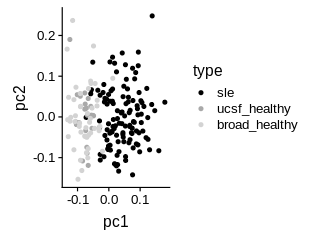

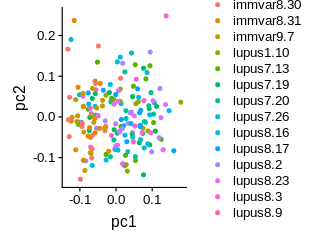

In [24]:
##pbmc_expr_prcomp <- prcomp(pbmc_expr)
pbmc_expr_prcomp <- prcomp(pbmc_expr_std)

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

In [25]:
pbmc_expr_prcomp <- prcomp(pbmc_expr_std[na.omit(match(deseq_sig_genes,rownames(pbmc_expr_std))),])

df <- rbind(data.frame(pc1=pbmc_expr_prcomp$rotation[sle_indices,1], pc2=pbmc_expr_prcomp$rotation[sle_indices,2], type="sle"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[ucsf_healthy_indices,2], type="ucsf_healthy"),
            data.frame(pc1=pbmc_expr_prcomp$rotation[broad_healthy_indices,1], pc2=pbmc_expr_prcomp$rotation[broad_healthy_indices,2], type="broad_healthy")
           )
df$batch = joined_pivot$batch_cov[match(rownames(df),joined_ind_cov_batch)]

# options(repr.plot.width = 4, repr.plot.height = 3)
# ggplot(aes(pc1,pc2,color=type),data=df)+geom_point()+scale_colour_manual(values=c("black","darkgray","lightgray"))

# ggplot(aes(pc1,pc2,color=batch),data=df)+geom_point()

# Figure 2A - heatmap

In [26]:
pbmc_col_clust <- hclust(dist(t(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),]),method = "euclidean"), method="ward.D")
pbmc_row_clust <- hclust(dist(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),],method = "euclidean"), method="ward.D")

all_expr <- data.frame(pbmc=pbmc_expr[,pbmc_col_clust$order],
                      cm=cm_expr[,pbmc_col_clust$order],
                      ncm=ncm_expr[,pbmc_col_clust$order],
                      dc=dc_expr[,pbmc_col_clust$order],
                      th=th_expr[,pbmc_col_clust$order],
                      tc=tc_expr[,pbmc_col_clust$order],
                       nk=nk_expr[,pbmc_col_clust$order],
                      b=b_expr[,pbmc_col_clust$order]
                      )
all_expr_sig <- all_expr[match(deseq_sig_genes,expr_gene_names),]

all_expr_std <- data.frame(pbmc=pbmc_expr_std[,pbmc_col_clust$order],
                      cm=cm_expr_std[,pbmc_col_clust$order],
                      ncm=ncm_expr_std[,pbmc_col_clust$order],
                      dc=dc_expr_std[,pbmc_col_clust$order],
                      th=th_expr_std[,pbmc_col_clust$order],
                      tc=tc_expr_std[,pbmc_col_clust$order],
                       nk=nk_expr_std[,pbmc_col_clust$order],
                      b=b_expr_std[,pbmc_col_clust$order]
                      )

all_expr_std_sig <- all_expr_std[match(deseq_sig_genes,expr_gene_names),]

ct_annotation_one <- data.frame(disease_pop_cov=joined_pivot$disease_pop_cov,
                           sledaiscore=joined_pivot$sledaiscore)
rownames(ct_annotation_one) <- colnames(pbmc_expr);

ct_annotation <- data.frame(type=factor(rep(cell_types,each=ncol(ncm_expr))),
#                            disease=factor(rep(c(rep("sle",ncol(cm_sle_expr)),
#                                                 rep("ctrl",ncol(cm_healthy_expr)))[pbmc_clust$order],
#                                               length(cell_types))),
                           disease_pop_cov=joined_pivot$disease_pop_cov[pbmc_col_clust$order],
                           sledaiscore=joined_pivot$sledaiscore[pbmc_col_clust$order])
rownames(ct_annotation) <- colnames(all_expr_std);


In [27]:
# options(repr.plot.width = 16, repr.plot.height = 16)

# breaksList = seq(-2, 2, by = .1)
# pheatmap_out <- pheatmap(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
#          cluster_rows=T, cluster_cols=F,annotation_col = ct_annotation_one[pbmc_col_clust$order,],#annotation_row = kmeans_annotation,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), 
#                          cutree_rows=8, 
#                          scale="row",fontsize=5,clustering_method="ward.D",clustering_distance_row="manhattan",# Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList) # Sets the breaks of the color scale as in breaksList

In [28]:
print(dim(pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order]))

[1] 209 188


In [29]:
ifn_crow <- read.table("ifn.lupus.crow.etal.txt")
crow_annotation <- matrix(nrow=nrow(all_expr_std_sig), ncol=1, 0);
crow_annotation[na.omit(match(ifn_crow$V1, rownames(all_expr_std_sig))),1] <- 1;
rownames(crow_annotation) <- rownames(all_expr_std_sig)
colnames(crow_annotation) <- "Crow"
crow_annotation <- as.data.frame(crow_annotation)

In [30]:
sum(crow_annotation$Crow)

[1] 25

In [31]:
pbmc_deseq_sig_annotation <- matrix(nrow=nrow(all_expr_std_sig), ncol=1, 0);
pbmc_deseq_sig_annotation[na.omit(match(pbmc_deseq_sig_genes, rownames(all_expr_std_sig))),1] <- 1;
rownames(pbmc_deseq_sig_annotation) <- rownames(all_expr_std_sig)
colnames(pbmc_deseq_sig_annotation) <- "PBMC Sig"
pbmc_deseq_sig_annotation <- as.data.frame(pbmc_deseq_sig_annotation)

In [32]:
dim(pbmc_deseq_sig_annotation)
length(pbmc_deseq_sig_genes)

[1] 209   1

[1] 149

In [33]:
row_annotations <- cbind(crow_annotation, pbmc_deseq_sig_annotation)

In [34]:
sum(row_annotations$Crow[row_annotations$"PBMC Sig"==1])

[1] 21

In [35]:
# options(repr.plot.width = 16, repr.plot.height = 16)
# breaksList = seq(-2, 2, by = .2)

# pheatmap_std_out <- pheatmap(all_expr_std_sig,
#          cluster_rows=T, cluster_cols=F, annotation_row = row_annotations, annotation_col = ct_annotation, #annotation_row = kmeans_annotation,
#          color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(length(breaksList)), # Defines the vector of colors for the legend (it has to be of the same lenght of breaksList)
#         breaks = breaksList, # Sets the breaks of the color scale as in breaksList
#         gaps_col=seq(ncol(cm_expr),ncol(cm_expr)*length(cell_types),ncol(cm_expr)),
#                          cutree_rows=8, 
#                          scale="none",fontsize=2,clustering_method="ward.D",clustering_distance_row="manhattan", filename="expr_std_heatmap.png",
#                             width=10, height=10, dpi=600)
# options(repr.plot.width = 10, repr.plot.height = 4)



In [36]:
joined_full=read.table('../figure1.ct.diff/CLUESImmVar_processed.V6_joined_pivot_cg_perc.txt', sep=',', header=T)
print(head(joined_full))
pbmc_use=pbmc_expr_std[match(pbmc_deseq_sig_genes,expr_gene_names),pbmc_col_clust$order]

inds=sapply(strsplit(colnames(pbmc_use),'_'), '[', 1)

joined_full_use=joined_full[match(inds, joined_full[['ind_cov']]), ]

sig=prcomp(t(pbmc_use))$x[, 1]


sig.sle=sig[grep('IGTB', names(sig), invert=T)]
joined_full_sle=joined_full_use[grep('IGTB', names(sig), invert=T), ]


#correlation with sledaiscore
cor(joined_full_sle[['sledaiscore']], sig.sle, use = 'complete.obs')

#correlation with mono and lymph
cor(joined_full_sle[['PercMono']], sig.sle, use = 'complete.obs')
cor(joined_full_sle[['PercLympho']], sig.sle, use = 'complete.obs')



  X ind_cov subjectid  pbmc disease_cov disease_pop_cov disease_pop_site_cov
1 0    1004      1004 1.674         sle        sleWHITE         sleWHITEUCSF
2 1    1014      1014 1.628         sle        sleWHITE         sleWHITEUCSF
3 2    1019      1019 1.845         sle        sleWHITE         sleWHITEUCSF
4 3    1045      1045 2.170         sle        sleASIAN         sleASIANUCSF
5 4    1051      1051 1.325         sle        sleASIAN         sleASIANUCSF
6 5    1054      1054 2.169         sle        sleASIAN         sleASIANUCSF
  batch_cov plaquenilnow cellceptnow steroralnow acrlymphopenia sledaiscore
1 lupus7.13            1           0           0              1           2
2 lupus7.13            1           0           1              0           2
3 lupus7.13            1           0           0              0           0
4 lupus7.13            1           0           1              0           4
5 lupus7.13            1           1           1              0           4
6 lup

[1] 0.1942172

[1] 0.5807265

[1] -0.2246171

## prediction 

In [37]:
#do LOO Cross Validation with lasso and return the predicted values

loo_cv <- function(mat_expr, outcome){
    k <- nrow(sledai)
    predictions <- c()
    for (i in 1:k) {
        model <- glmnet(mat_expr[-i,], outcome[-i])
        min_s=model$lambda[which.min(model$lambda)]
        p=predict(model, newx=t(as.matrix(mat_expr[i, ])), s=min_s)
        predictions <- c(predictions, p)                                  
        }
    return(predictions)
    }


In [38]:

# all_de=cv.glmnet(t(pbmc_expr_pred), sledai[['sledaiscore']], nfolds=nrow(sledai))

# min_error=which(all_de$glmnet.fit$lambda == all_de$lambda.min)
# r2 <- all_de$glmnet.fit$dev.ratio[min_error]
# rsq = 1 - all_de$cvm/var(sledai[['sledaiscore']])
# rsq=rsq[min_error]
# print(r2)
# print(rsq)

# all_ifn=cv.glmnet(t(pbmc_ifn), sledai[['sledaiscore']], nfolds =nrow(sledai))

# min_error=which(all_ifn$glmnet.fit$lambda == all_ifn$lambda.min)
# r2 <- all_ifn$glmnet.fit$dev.ratio[min_error]
# rsq = 1 - all_ifn$cvm/var(sledai[['sledaiscore']])
# rsq=rsq[min_error]
# print(r2)
# print(rsq)

# all_includect=cv.glmnet(t(all_includect_expr), sledai[['sledaiscore']], nfolds =  nrow(sledai))

# min_error=which(all_includect$glmnet.fit$lambda == all_includect$lambda.min)
# r2 <- all_includect$glmnet.fit$dev.ratio[min_error]
# rsq = 1 - all_de$cvm/var(sledai[['sledaiscore']])
# rsq=rsq[min_error]
# print(r2)
# print(rsq)


pbmc_expr_pred=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order]
sledai=cbind(ct_annotation_one, joined_pivot[, 13:24])
sledai=sledai[pbmc_col_clust$order,]
print(head(sledai))

print(dim(sledai))
print(dim(pbmc_expr_pred))


pbmc_pred=loo_cv(t(pbmc_expr_pred), sledai[['sledaiscore']])

pbmc_ifn=pbmc_expr_pred[match(ifn_crow[['V1']], rownames(pbmc_expr_pred)),  ]
pbmc_ifn=pbmc_ifn[!is.na(rownames(pbmc_ifn)), ]

ifn_pred=loo_cv(t(pbmc_ifn), sledai[['sledaiscore']])

#now include CT composition featuers
all_includect_expr=rbind(pbmc_expr_pred, t(sledai[,3:ncol(sledai)]))
all_includect_expr=all_includect_expr[complete.cases(all_includect_expr), ]
#print(head(all_includect_expr))


pbmc_ct_comp_pred=loo_cv(t(all_includect_expr), sledai[['sledaiscore']])

                    disease_pop_cov sledaiscore         B        DB         MK
IGTB1793_immvar8.30    healthyWHITE           0  7.447062 0.6899833 0.07137759
IGTB1819_immvar8.30    healthyWHITE           0 12.467260 0.6809848 0.07857517
IGTB1987_immvar8.31    healthyWHITE           0 12.053708 1.0375343 0.12206286
IGTB1506_immvar9.7     healthyWHITE           0 12.899065 0.6772009 0.06449532
IGTB256_lupus8.17      healthyWHITE           0 14.581844 1.7155111         NA
IGTB1650_immvar8.31    healthyWHITE           0 11.929057 0.7288630 0.04859086
                           NK    Progen   ProlifT       Tc       Th       cDC
IGTB1793_immvar8.30  7.661194 0.6899833 0.4758506 28.62241 36.83084 1.4751368
IGTB1819_immvar8.30  7.176532 0.8381351 0.2619172 27.26558 34.33735 0.8381351
IGTB1987_immvar8.31  4.974062 0.7934086 0.1830943 20.47605 37.90052 0.7934086
IGTB1506_immvar9.7  10.029023 0.4514673 0.3224766 21.70268 32.63463 1.2254112
IGTB256_lupus8.17    7.791279 0.5003574 0.1429593 20.4431

In [39]:
#prediction with all cts
print(dim(all_expr_std_sig))
print(head(ct_annotation))

genes_use=setdiff(deseq_sig_genes, pbmc_deseq_sig_genes)
print(length(genes_use))

ifn_genes_use=intersect(ifn_crow[['V1']] , expr_gene_names)
all_expr_cts_ifn <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
                      cm=cm_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                      ncm=ncm_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                      dc=dc_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                      th=th_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                      tc=tc_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                       nk=nk_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order],
                      b=b_expr_std[match(ifn_genes_use,expr_gene_names),pbmc_col_clust$order]
                      )



all_expr_cts <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
                      cm=cm_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                      ncm=ncm_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                      dc=dc_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                      th=th_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                      tc=tc_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                       nk=nk_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order],
                      b=b_expr_std[match(genes_use,expr_gene_names),pbmc_col_clust$order]
                      )
# all_de_cts=cv.glmnet(t(all_expr_cts), sledai[['sledaiscore']], nfolds=nrow(sledai))

# min_error=which(all_de_cts$glmnet.fit$lambda == all_de_cts$lambda.min)
# r2 <- all_de_cts$glmnet.fit$dev.ratio[min_error]
# rsq = 1 - all_de$cvm/var(sledai[['sledaiscore']])
# #rsq=rsq[min_error]
# print(r2)
# print(rsq[min_error])


#LOO CV get predictions this time
ct_expr_pred=loo_cv(t(all_expr_cts), sledai[['sledaiscore']])
ct_expr_pred_ifn=loo_cv(t(all_expr_cts_ifn), sledai[['sledaiscore']])

##add the CT comp to CT expr
all_includect_comp_expr=rbind(all_expr_cts, t(sledai[,3:ncol(sledai)]))
all_includect_comp_expr=all_includect_comp_expr[complete.cases(all_includect_comp_expr), ]

ct_expr_ct_comp_pred=loo_cv(t(all_includect_comp_expr), sledai[['sledaiscore']])


[1]  209 1504
                         type disease_pop_cov sledaiscore
pbmc.IGTB1793_immvar8.30 PBMC    healthyWHITE           0
pbmc.IGTB1819_immvar8.30 PBMC    healthyWHITE           0
pbmc.IGTB1987_immvar8.31 PBMC    healthyWHITE           0
pbmc.IGTB1506_immvar9.7  PBMC    healthyWHITE           0
pbmc.IGTB256_lupus8.17   PBMC    healthyWHITE           0
pbmc.IGTB1650_immvar8.31 PBMC    healthyWHITE           0
[1] 60


In [40]:
head(sledai[['sledaiscore']])
head(pbmc_pred)

[1] 0 0 0 0 0 0

[1]  0.1173684 -1.3965203 -2.5137827 -1.0693863 -0.7199708  3.2306452

Warning message:
“package ‘pROC’ was built under R version 3.5.2”Type 'citation("pROC")' for a citation.

Attaching package: ‘pROC’

The following object is masked from ‘package:glmnet’:

    auc

The following objects are masked from ‘package:stats’:

    cov, smooth, var

Warning message in roc.default(sledai[["sledaiscore"]], pbmc_pred):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases
Warning message in roc.default(sledai[["sledaiscore"]], ifn_pred):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases
Warning message in roc.default(sledai[["sledaiscore"]], ct_expr_pred):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Settin

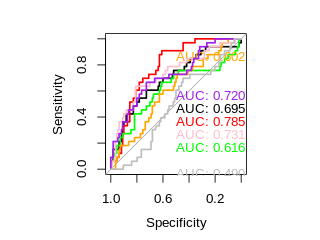

In [41]:
library(pROC)

load('plink_sledai_lm_roc.RData')


#pdf('sledaiscore.prediction.pdf')
par(pty="s")
plot(roc(sledai[['sledaiscore']], pbmc_pred), print.auc=TRUE)
plot(roc(sledai[['sledaiscore']], ifn_pred), col='red', add =T, print.auc.y = .4, print.auc=TRUE)
plot(roc(sledai[['sledaiscore']], ct_expr_pred), col='green', add =T, print.auc.y = .2, print.auc=TRUE)
plot(roc(sledai[['sledaiscore']], ct_expr_pred_ifn), col='orange', add =T, print.auc.y = .9, print.auc=TRUE)

plot(roc(sledai[['sledaiscore']], ct_expr_ct_comp_pred), col='pink', add =T, print.auc.y = .3, print.auc=TRUE)
plot(roc(sledai[['sledaiscore']], pbmc_ct_comp_pred ), col='purple', add =T, print.auc.y = .6, print.auc=TRUE)
plot(roc.obj, col='grey', add =T, print.auc.y = 0, print.auc=TRUE)

#dev.off()

In [42]:
#predict case/control status 

sledai[['disease']]=1
sledai[['disease']][grep('healthy', sledai[['disease_pop_cov']])]=0

ifn_pred=loo_cv(t(pbmc_ifn), sledai[['disease']])
pbmc_pred=loo_cv(t(pbmc_expr_pred), sledai[['disease']])
pbmc_ct_comp_pred=loo_cv(t(all_includect_expr), sledai[['disease']])
ct_expr_pred=loo_cv(t(all_expr_cts), sledai[['disease']])
ct_expr_ct_comp_pred=loo_cv(t(all_includect_comp_expr), sledai[['disease']])


Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases
Setting levels: control = 0, case = 1
Setting direction: controls < cases


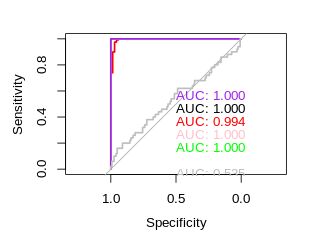

In [43]:
#pdf('disease.status.prediction.pdf')
load('plink_case_control_lm_roc.RData')
plot(roc(sledai[['disease']], pbmc_pred), print.auc=TRUE)
plot(roc(sledai[['disease']], ifn_pred), col='red', add =T, print.auc.y = .4, print.auc=TRUE)
plot(roc(sledai[['disease']], ct_expr_pred), col='green', add =T, print.auc.y = .2, print.auc=TRUE)
plot(roc(sledai[['disease']], ct_expr_ct_comp_pred), col='pink', add =T, print.auc.y = .3, print.auc=TRUE)
plot(roc(sledai[['disease']], pbmc_ct_comp_pred ), col='purple', add =T, print.auc.y = .6, print.auc=TRUE)

plot(roc.obj, col='grey', add =T, print.auc.y = 0, print.auc=TRUE)

#dev.off()

In [44]:
# #ty prediction from full expression
# pbmc_expr_full=pbmc_expr_std[,pbmc_col_clust$order]
# all_includect_full=rbind(pbmc_expr_full, t(sledai[,3:ncol(sledai)]))
# all_includect_full=all_includect_full[complete.cases(all_includect_full), ]

# all_expr_cts_full <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
#                       cm=cm_expr_std[,pbmc_col_clust$order],
#                       ncm=ncm_expr_std[,pbmc_col_clust$order],
#                       dc=dc_expr_std[,pbmc_col_clust$order],
#                       th=th_expr_std[,pbmc_col_clust$order],
#                       tc=tc_expr_std[,pbmc_col_clust$order],
#                        nk=nk_expr_std[,pbmc_col_clust$order],
#                       b=b_expr_std[,pbmc_col_clust$order]
#                       )

# all_expr_cts_perc_full=rbind(all_expr_cts_full, t(sledai[,3:ncol(sledai)]))
# all_expr_cts_perc_full=all_expr_cts_perc_full[complete.cases(all_expr_cts_perc_full), ]


# pbmc_full_pred=loo_cv(t(pbmc_expr_full), sledai[['disease']])
# pbmc_full_includect_pred=loo_cv(t(all_includect_full), sledai[['disease']])


# plot(roc(sledai[['disease']], pbmc_full_pred), print.auc=TRUE)
# plot(roc(sledai[['disease']], pbmc_full_includect_pred), col='red', add =T, print.auc.y = .4, print.auc=TRUE)







# SVM

In [ ]:
#test just composition

In [45]:
comp = sledai[,c(2:(ncol(sledai) - 1))]
head(comp)

,sledaiscore,B,DB,MK,NK,Progen,ProlifT,Tc,Th,cDC,cM,ncM,pDC
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IGTB1793_immvar8.30,0,7.447062,0.6899833,0.07137759,7.661194,0.6899833,0.4758506,28.62241,36.83084,1.4751368,12.87176,2.450631,0.7137759
IGTB1819_immvar8.30,0,12.467260,0.6809848,0.07857517,7.176532,0.8381351,0.2619172,27.26558,34.33735,0.8381351,12.88633,2.016763,1.1524358
IGTB1987_immvar8.31,0,12.053708,1.0375343,0.12206286,4.974062,0.7934086,0.1830943,20.47605,37.90052,0.7934086,14.86115,5.950565,0.8544400
IGTB1506_immvar9.7,0,12.899065,0.6772009,0.06449532,10.029023,0.4514673,0.3224766,21.70268,32.63463,1.2254112,13.31828,5.449855,1.2254112
IGTB256_lupus8.17,0,14.581844,1.7155111,NA,7.791279,0.5003574,0.1429593,20.44317,34.31022,2.0014296,13.65261,3.752680,1.1079342
IGTB1650_immvar8.31,0,11.929057,0.7288630,0.04859086,17.930029,0.5344995,0.2915452,20.21380,31.87561,1.1418853,11.12731,3.522838,0.6559767


In [50]:
comp_pred = data.frame()
for(i in 1:nrow(comp)){
    test = comp[i,]
    train = comp[-i,]
#     print(i)
    model = svm(sledaiscore ~ ., data = train)
#     print("model")
    pred = predict(model, test)
    if(length(pred) > 0){
        #print(pred)
        a = as.data.frame(cbind(test$sledaiscore, pred))
        colnames(a) = c("sledai", "prediction")
        comp_pred = rbind(comp_pred, a)        
    } 
}


Warning message in roc.default(comp_pred$sledai, comp_pred$prediction):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases


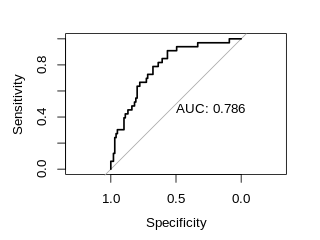

In [51]:
plot(roc(comp_pred$sledai, comp_pred$prediction), print.auc=TRUE)

## testing IFN in SVM model 

In [52]:
df.ifn = cbind(sledaiscore = comp$sledaiscore, t(pbmc_ifn))

In [53]:
head(df.ifn)

,sledaiscore,IFIT1,OASL,LY6E,OAS2,OAS3,IFI44,MX1,IFI6,EIF2AK2,⋯,IRF7,CD69,LGALS3BP,IL1RN,APOBEC3B,RGS1,EREG,THBS1,SERPING1,FCGR1A
IGTB1793_immvar8.30,0,-0.6093169,-0.9176580,-0.7989998,-0.6574322,-0.6312773,-0.5735622,-0.3540261,-0.8470690,-0.5953572,⋯,-0.7916040,0.3640575,0.399431976,-1.876220,-0.6790764,-0.4955003,-0.8006364,0.3606077,-1.2148021,-1.1175196
IGTB1819_immvar8.30,0,-0.7254768,-0.9865159,-0.7144985,-0.8567921,-0.7069506,-0.8400492,-0.7569764,-0.9553814,-0.5724721,⋯,-0.5553260,-0.3558028,0.002213882,-1.018096,-0.8624318,-1.0641901,-0.4363476,-0.3118865,-0.8670860,-1.3661759
IGTB1987_immvar8.31,0,-0.6890233,-0.2705246,-0.4194642,-0.8402045,-0.5765069,-0.6195298,-0.3146100,-0.4701409,-0.2013264,⋯,-0.5322623,-0.5306511,-0.393789084,-1.351000,1.0341533,-0.3656907,-1.6427698,0.2166249,-1.3158518,-1.2175799
IGTB1506_immvar9.7,0,-0.7976873,-1.1360208,-0.9409923,-0.9980690,-1.5987956,-1.0407710,-0.9896900,-0.9573173,-0.5500123,⋯,-0.3491492,-1.2232548,-1.558432362,-1.759385,-0.2521683,-1.4693272,-0.9259336,-0.1088618,-1.1711599,-0.9092447
IGTB256_lupus8.17,0,-0.9230161,-0.8115644,-0.7455325,-0.9725961,-0.8701002,-0.9816459,-0.9726022,-0.7998626,-0.5723664,⋯,-0.3021853,-0.2952448,-1.032453233,-1.093152,-0.1390976,-0.6994362,-0.8154682,-0.4648802,-0.9105304,-0.9294736
IGTB1650_immvar8.31,0,-0.2614647,-1.0049210,-0.5157031,-0.7621911,-0.7376124,-0.9401519,-0.2445850,-0.9022834,-0.2118526,⋯,-0.6005310,-0.3042610,-0.710637890,-1.875616,-1.1314209,-0.7188243,-1.9175240,-0.8713217,-0.9430776,-1.6129957


In [55]:
ifn_pred = data.frame()
for(i in 1:nrow(df.ifn)){
    test = t(as.data.frame(df.ifn[i,]))
    train = as.data.frame(df.ifn[-i,])
#     print(i)
    model = svm(sledaiscore ~ ., data = train)
#     print("model")
    pred = predict(model, test)
    if(length(pred) > 0){
#        print(pred)
        a = as.data.frame(cbind(as.data.frame(test)$sledaiscore, pred))
        colnames(a) = c("sledai", "prediction")
        ifn_pred = rbind(ifn_pred, a)        
    }


}


Warning message in roc.default(ifn_pred$sledai, ifn_pred$prediction):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases


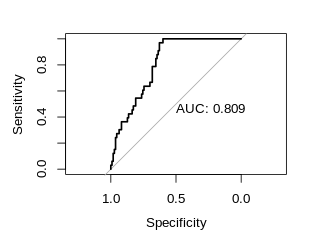

In [56]:
plot(roc(ifn_pred$sledai, ifn_pred$prediction), print.auc=TRUE)

## testing CT DE genes SVM model

In [57]:
head(all_expr_cts)
tail(all_expr_cts)
df.ctgenes = cbind(sledaiscore = comp$sledaiscore, t(all_expr_cts))
head(df.ctgenes)

,IGTB1793_immvar8.30,IGTB1819_immvar8.30,IGTB1987_immvar8.31,IGTB1506_immvar9.7,IGTB256_lupus8.17,IGTB1650_immvar8.31,IGTB1650_lupus7.13,IGTB1539_immvar9.7,IGTB1539_lupus8.9,IGTB884_immvar8.31,⋯,1078_lupus7.13,1196_lupus7.19,1250_lupus7.20,1584_lupus8.16,901347200_lupus7.13,1597_lupus8.16,1615_lupus1.10,1791_lupus8.23,1414_lupus8.2,1602_lupus1.10
DDIT4,-0.1380523,-1.4339515,-0.9813919,-1.3602590,-1.1685340,-0.817399152,-0.76244995,0.45694329,-0.9780494,-0.0228658,⋯,2.4109812,0.3301156,0.6825502,0.6404763,0.4732579,0.5184486,0.6411760,0.5562698,1.4059038,0.75723304
DTX3L,0.1488743,-0.3911287,-0.8026346,-0.6714348,-0.0602574,-0.005579298,0.07710816,-0.40836443,-0.9226296,-2.0918955,⋯,0.8594857,1.6983916,-0.2334518,0.8731862,0.8356903,-0.3079267,0.2612363,0.7160771,0.1790021,-0.06150895
EPSTI1,0.2746939,-0.8547055,-0.6613249,-1.1671790,-0.4669008,-0.275859536,-0.46670881,-0.03817715,-0.5526987,-0.8866024,⋯,0.9732496,0.7945496,0.7664435,0.8640409,0.4104819,0.4748953,0.5958000,0.7097738,0.7088140,0.36066855
IRF7,-0.4166379,-0.5952712,-0.8932966,-0.9850588,-0.3191558,-0.538980268,-0.54556497,-0.43123156,-1.0107374,-0.7851393,⋯,1.4503323,1.0614350,1.0806823,0.7274861,0.7087316,0.3885064,0.5719866,0.8208778,0.8397646,0.19184974
SAMD9L,-0.3497319,-0.4668344,-1.0386885,-0.9851762,-1.3702811,-0.960834860,-0.06505207,0.09516912,-0.9063800,-1.9386805,⋯,0.3845038,0.8927459,0.4508476,1.1260522,0.5868085,-0.2119857,0.2099992,0.4994667,0.1110704,0.06378972
IFIH1,-0.1342574,-0.3485365,-1.1274546,-1.3076966,-0.8406140,-1.566464766,-0.73329904,-0.46875805,-0.6878854,-0.2279362,⋯,1.0302170,0.8746999,0.6361816,0.7152333,0.3686600,-0.2230443,-0.1277743,0.2794772,-0.2236603,0.41749133


,IGTB1793_immvar8.30,IGTB1819_immvar8.30,IGTB1987_immvar8.31,IGTB1506_immvar9.7,IGTB256_lupus8.17,IGTB1650_immvar8.31,IGTB1650_lupus7.13,IGTB1539_immvar9.7,IGTB1539_lupus8.9,IGTB884_immvar8.31,⋯,1078_lupus7.13,1196_lupus7.19,1250_lupus7.20,1584_lupus8.16,901347200_lupus7.13,1597_lupus8.16,1615_lupus1.10,1791_lupus8.23,1414_lupus8.2,1602_lupus1.10
NR4A2,-0.7481755,-1.0757148,-1.0292955,-1.5513647,-0.80765036,-1.5054243,-0.4841347,-0.4000462,-1.6237980,-0.9619700,⋯,1.270234,1.4034779,0.24169597,1.4487180,1.275803,1.1666570,0.1466001,0.5410850,0.31957152,0.1599085
CD69,0.2975466,-0.2324069,-0.9617386,-1.0801469,0.07727208,-1.2309902,-0.1830530,-1.2957030,-1.3992637,-0.5911783,⋯,1.320152,1.3654481,0.23025502,1.9365154,1.523727,-0.3486140,-0.6117928,0.5615264,0.06723962,0.1110263
SIK1,-1.5297686,-1.4907857,-0.9442150,-1.9021815,-0.88970448,-1.6885516,-0.4619336,-0.5953571,-0.3611253,-0.6296901,⋯,1.454275,1.1145782,1.47871445,1.2057844,1.269777,1.1098458,0.8759669,1.1645155,0.77046374,0.7415529
MYADM,-1.0619659,-0.6293736,-1.4370791,-0.0250125,-1.51286185,-1.0710605,-0.4289397,-0.5637567,-1.4280828,-1.8605278,⋯,1.425509,0.9494006,0.57847024,1.7137571,1.317770,0.2839043,-0.2699169,0.2545518,0.35390588,-0.6572184
MIR24-2,-0.9587786,-0.9429080,-1.7330691,-1.2778302,0.21389537,-0.8875627,-0.4419154,-0.4869215,-1.0156979,-1.1160442,⋯,1.887261,1.3462137,-0.08173264,1.7948345,1.223681,1.1767254,0.4226246,-0.2645945,-0.69714684,0.1358372
ZNF331,-1.2428234,-0.8995356,-0.3829803,-1.5770220,-0.67344743,-1.5367305,-1.0909285,-0.8623919,-1.0947443,0.0551372,⋯,2.492760,2.3126927,2.20046146,0.8559399,1.957686,1.1446300,0.9099835,0.7248338,1.17275501,0.3204461


,sledaiscore,DDIT4,DTX3L,EPSTI1,IRF7,SAMD9L,IFIH1,EIF2AK2,DDX60,DDX58,⋯,LAIR2,JUN,RP11-386I14.4,FOS,NR4A2,CD69,SIK1,MYADM,MIR24-2,ZNF331
IGTB1793_immvar8.30,0,-0.1380523,0.148874320,0.2746939,-0.4166379,-0.3497319,-0.1342574,-0.774815280,0.3884381,-0.1926161,⋯,-0.1208003,-0.3832817,-1.02007940,-1.0480293,-0.7481755,0.29754658,-1.5297686,-1.0619659,-0.9587786,-1.2428234
IGTB1819_immvar8.30,0,-1.4339515,-0.391128742,-0.8547055,-0.5952712,-0.4668344,-0.3485365,-0.254328318,-0.8286887,-0.7295873,⋯,1.8907697,-0.7116074,-0.46317530,-0.6106872,-1.0757148,-0.23240687,-1.4907857,-0.6293736,-0.9429080,-0.8995356
IGTB1987_immvar8.31,0,-0.9813919,-0.802634570,-0.6613249,-0.8932966,-1.0386885,-1.1274546,0.009457037,-0.7597718,-1.4635758,⋯,2.5754012,-0.8620366,-0.44340843,-0.9998475,-1.0292955,-0.96173859,-0.9442150,-1.4370791,-1.7330691,-0.3829803
IGTB1506_immvar9.7,0,-1.3602590,-0.671434849,-1.1671790,-0.9850588,-0.9851762,-1.3076966,-0.863369622,-1.1782787,-0.5205768,⋯,-0.3772870,-0.3251951,-1.57990048,-0.9341428,-1.5513647,-1.08014686,-1.9021815,-0.0250125,-1.2778302,-1.5770220
IGTB256_lupus8.17,0,-1.1685340,-0.060257402,-0.4669008,-0.3191558,-1.3702811,-0.8406140,-0.651471502,-1.2132971,-0.7862962,⋯,-0.9041449,-0.7609217,0.09493962,-0.5886078,-0.8076504,0.07727208,-0.8897045,-1.5128618,0.2138954,-0.6734474
IGTB1650_immvar8.31,0,-0.8173992,-0.005579298,-0.2758595,-0.5389803,-0.9608349,-1.5664648,-0.455213691,0.1045874,-0.2730960,⋯,-0.5632386,-1.1268508,-0.16642714,-1.2320738,-1.5054243,-1.23099022,-1.6885516,-1.0710605,-0.8875627,-1.5367305


In [58]:
colnames(df.ctgenes) = c("sledaiscore", seq(1, (ncol(df.ctgenes) - 1)))
head(df.ctgenes)

,sledaiscore,1,2,3,4,5,6,7,8,9,⋯,411,412,413,414,415,416,417,418,419,420
IGTB1793_immvar8.30,0,-0.1380523,0.148874320,0.2746939,-0.4166379,-0.3497319,-0.1342574,-0.774815280,0.3884381,-0.1926161,⋯,-0.1208003,-0.3832817,-1.02007940,-1.0480293,-0.7481755,0.29754658,-1.5297686,-1.0619659,-0.9587786,-1.2428234
IGTB1819_immvar8.30,0,-1.4339515,-0.391128742,-0.8547055,-0.5952712,-0.4668344,-0.3485365,-0.254328318,-0.8286887,-0.7295873,⋯,1.8907697,-0.7116074,-0.46317530,-0.6106872,-1.0757148,-0.23240687,-1.4907857,-0.6293736,-0.9429080,-0.8995356
IGTB1987_immvar8.31,0,-0.9813919,-0.802634570,-0.6613249,-0.8932966,-1.0386885,-1.1274546,0.009457037,-0.7597718,-1.4635758,⋯,2.5754012,-0.8620366,-0.44340843,-0.9998475,-1.0292955,-0.96173859,-0.9442150,-1.4370791,-1.7330691,-0.3829803
IGTB1506_immvar9.7,0,-1.3602590,-0.671434849,-1.1671790,-0.9850588,-0.9851762,-1.3076966,-0.863369622,-1.1782787,-0.5205768,⋯,-0.3772870,-0.3251951,-1.57990048,-0.9341428,-1.5513647,-1.08014686,-1.9021815,-0.0250125,-1.2778302,-1.5770220
IGTB256_lupus8.17,0,-1.1685340,-0.060257402,-0.4669008,-0.3191558,-1.3702811,-0.8406140,-0.651471502,-1.2132971,-0.7862962,⋯,-0.9041449,-0.7609217,0.09493962,-0.5886078,-0.8076504,0.07727208,-0.8897045,-1.5128618,0.2138954,-0.6734474
IGTB1650_immvar8.31,0,-0.8173992,-0.005579298,-0.2758595,-0.5389803,-0.9608349,-1.5664648,-0.455213691,0.1045874,-0.2730960,⋯,-0.5632386,-1.1268508,-0.16642714,-1.2320738,-1.5054243,-1.23099022,-1.6885516,-1.0710605,-0.8875627,-1.5367305


In [59]:
ctgenes_pred = data.frame()
for(i in 1:nrow(df.ctgenes)){
    test = t(as.data.frame(df.ctgenes[i,]))
    train = as.data.frame(df.ctgenes[-i,])
#     print(i)
    model = svm(sledaiscore ~ ., data = train)
#     print("model")
    pred = predict(model, test)
    if(length(pred) > 0){
#        print(pred)
        a = as.data.frame(cbind(as.data.frame(test)$sledaiscore, pred))
        colnames(a) = c("sledai", "prediction")
        ctgenes_pred = rbind(ctgenes_pred, a)        
    }

}


df.ctgenes[i, ] 
      0.8390515 
df.ctgenes[i, ] 
     0.08208554 
df.ctgenes[i, ] 
    -0.02553075 
df.ctgenes[i, ] 
      0.5674158 
df.ctgenes[i, ] 
      0.2065398 
df.ctgenes[i, ] 
      0.3628208 
df.ctgenes[i, ] 
      0.2214166 
df.ctgenes[i, ] 
      0.1725263 
df.ctgenes[i, ] 
    -0.03520228 
df.ctgenes[i, ] 
      0.8591421 
df.ctgenes[i, ] 
      0.1422048 
df.ctgenes[i, ] 
      0.2865585 
df.ctgenes[i, ] 
      0.1666595 
df.ctgenes[i, ] 
      0.7058544 
df.ctgenes[i, ] 
   -0.003590697 
df.ctgenes[i, ] 
    -0.08182829 
df.ctgenes[i, ] 
      0.4131651 
df.ctgenes[i, ] 
      0.1147876 
df.ctgenes[i, ] 
      0.3980033 
df.ctgenes[i, ] 
     0.02068942 
df.ctgenes[i, ] 
      0.3522374 
df.ctgenes[i, ] 
      0.2691786 
df.ctgenes[i, ] 
      0.2316833 
df.ctgenes[i, ] 
       0.410468 
df.ctgenes[i, ] 
      0.2998612 
df.ctgenes[i, ] 
       0.575176 
df.ctgenes[i, ] 
      0.2801268 
df.ctgenes[i, ] 
      0.3278193 
df.ctgenes[i, ] 
       0.305811 
df.ctgenes[i, 

Warning message in roc.default(ctgenes_pred$sledai, ctgenes_pred$prediction):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases


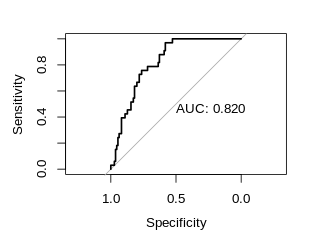

In [60]:
plot(roc(ctgenes_pred$sledai, ctgenes_pred$prediction), print.auc=TRUE)



## SVM on all feature compbinations 

In [ ]:
# ifn_pred=loo_cv(t(pbmc_ifn), sledai[['disease']])
# pbmc_pred=loo_cv(t(pbmc_expr_pred), sledai[['disease']])
# pbmc_ct_comp_pred=loo_cv(t(all_includect_expr), sledai[['disease']])
# ct_expr_pred=loo_cv(t(all_expr_cts), sledai[['disease']])
# ct_expr_ct_comp_pred=loo_cv(t(all_includect_comp_expr), sledai[['disease']])



In [74]:
df.pbmc = cbind(comp$sledaiscore, t(pbmc_expr_pred))
df.pbmc_ct = cbind(comp$sledaiscore, t(all_includect_expr))
df.ct_comp = cbind(comp$sledaiscore, t(all_includect_comp_expr))


In [62]:
colnames(df.pbmc) = c("sledaiscore", seq(1, (ncol(df.pbmc) - 1)))
colnames(df.pbmc_ct) = c("sledaiscore", seq(1, (ncol(df.pbmc_ct) - 1)))
colnames(df.ct_comp) = c("sledaiscore", seq(1, (ncol(df.ct_comp) - 1)))
head(df.pbmc)
head(df.pbmc_ct)
head(df.ct_comp)

,sledaiscore,1,2,3,4,5,6,7,8,9,⋯,200,201,202,203,204,205,206,207,208,209
IGTB1793_immvar8.30,0,1.293101,-1.0764113,-1.5537948,-1.4792206,-1.489199,-1.678632,0.5724968,-1.355202,-1.5382702,⋯,-1.8430568,-0.7218486,-1.9280724,-1.726604,-1.015150,0.3640575,-0.6463387,-2.1501730,-1.9238772,-0.50084369
IGTB1819_immvar8.30,0,1.689923,-1.3079273,-1.1441417,-1.7977183,-2.149596,-1.198613,1.1932510,-1.674519,-1.5587163,⋯,1.5686764,-1.7301331,-0.3831368,-1.743156,-1.568505,-0.3558028,-1.9114278,-2.1306085,-1.1753080,-0.89348695
IGTB1987_immvar8.31,0,1.182064,-0.9460802,-0.9422623,-1.6686754,-1.632334,-0.362181,1.5282223,-1.489630,-0.7967442,⋯,-0.5971987,-0.8279606,-0.1949880,-1.498777,-1.643696,-0.5306511,-1.4001153,-1.2381056,-0.4448333,-0.20294722
IGTB1506_immvar9.7,0,1.719851,-0.5947438,-1.1211787,-0.5310276,-1.042885,-1.778081,1.6135667,-2.026571,-2.0422438,⋯,-0.7933171,-1.3260501,-0.7945938,-1.642028,-2.093647,-1.2232548,-2.2136068,-0.3683394,-0.9334648,-1.07028550
IGTB256_lupus8.17,0,1.834380,-0.8514521,-1.1116239,-0.9913231,-1.199040,-1.175193,1.4984748,-1.080209,-1.2981508,⋯,-1.5922733,-1.8580339,-0.6177408,-1.731354,-1.036938,-0.2952448,-1.1029840,-0.7621903,-1.4736531,-0.02087915
IGTB1650_immvar8.31,0,1.187485,-1.5377860,-1.8845852,-1.8490702,-1.485485,-1.022135,0.3979871,-1.715160,-1.7976238,⋯,1.1176687,-0.7274344,-0.9395865,-1.346045,-1.608207,-0.3042610,-1.0371139,-2.8217711,-1.6720596,-0.17036723


,sledaiscore,1,2,3,4,5,6,7,8,9,⋯,208,209,210,211,212,213,214,215,216,217
IGTB1793_immvar8.30,0,1.293101,-1.0764113,-1.5537948,-1.4792206,-1.489199,-1.678632,0.5724968,-1.355202,-1.5382702,⋯,-1.9238772,-0.50084369,7.447062,0.6899833,7.661194,28.62241,36.83084,1.4751368,12.87176,2.450631
IGTB1819_immvar8.30,0,1.689923,-1.3079273,-1.1441417,-1.7977183,-2.149596,-1.198613,1.1932510,-1.674519,-1.5587163,⋯,-1.1753080,-0.89348695,12.467260,0.6809848,7.176532,27.26558,34.33735,0.8381351,12.88633,2.016763
IGTB1987_immvar8.31,0,1.182064,-0.9460802,-0.9422623,-1.6686754,-1.632334,-0.362181,1.5282223,-1.489630,-0.7967442,⋯,-0.4448333,-0.20294722,12.053708,1.0375343,4.974062,20.47605,37.90052,0.7934086,14.86115,5.950565
IGTB1506_immvar9.7,0,1.719851,-0.5947438,-1.1211787,-0.5310276,-1.042885,-1.778081,1.6135667,-2.026571,-2.0422438,⋯,-0.9334648,-1.07028550,12.899065,0.6772009,10.029023,21.70268,32.63463,1.2254112,13.31828,5.449855
IGTB256_lupus8.17,0,1.834380,-0.8514521,-1.1116239,-0.9913231,-1.199040,-1.175193,1.4984748,-1.080209,-1.2981508,⋯,-1.4736531,-0.02087915,14.581844,1.7155111,7.791279,20.44317,34.31022,2.0014296,13.65261,3.752680
IGTB1650_immvar8.31,0,1.187485,-1.5377860,-1.8845852,-1.8490702,-1.485485,-1.022135,0.3979871,-1.715160,-1.7976238,⋯,-1.6720596,-0.17036723,11.929057,0.7288630,17.930029,20.21380,31.87561,1.1418853,11.12731,3.522838


,sledaiscore,1,2,3,4,5,6,7,8,9,⋯,419,420,421,422,423,424,425,426,427,428
IGTB1793_immvar8.30,0,-0.1380523,0.148874320,0.2746939,-0.4166379,-0.3497319,-0.1342574,-0.774815280,0.3884381,-0.1926161,⋯,-0.9587786,-1.2428234,7.447062,0.6899833,7.661194,28.62241,36.83084,1.4751368,12.87176,2.450631
IGTB1819_immvar8.30,0,-1.4339515,-0.391128742,-0.8547055,-0.5952712,-0.4668344,-0.3485365,-0.254328318,-0.8286887,-0.7295873,⋯,-0.9429080,-0.8995356,12.467260,0.6809848,7.176532,27.26558,34.33735,0.8381351,12.88633,2.016763
IGTB1987_immvar8.31,0,-0.9813919,-0.802634570,-0.6613249,-0.8932966,-1.0386885,-1.1274546,0.009457037,-0.7597718,-1.4635758,⋯,-1.7330691,-0.3829803,12.053708,1.0375343,4.974062,20.47605,37.90052,0.7934086,14.86115,5.950565
IGTB1506_immvar9.7,0,-1.3602590,-0.671434849,-1.1671790,-0.9850588,-0.9851762,-1.3076966,-0.863369622,-1.1782787,-0.5205768,⋯,-1.2778302,-1.5770220,12.899065,0.6772009,10.029023,21.70268,32.63463,1.2254112,13.31828,5.449855
IGTB256_lupus8.17,0,-1.1685340,-0.060257402,-0.4669008,-0.3191558,-1.3702811,-0.8406140,-0.651471502,-1.2132971,-0.7862962,⋯,0.2138954,-0.6734474,14.581844,1.7155111,7.791279,20.44317,34.31022,2.0014296,13.65261,3.752680
IGTB1650_immvar8.31,0,-0.8173992,-0.005579298,-0.2758595,-0.5389803,-0.9608349,-1.5664648,-0.455213691,0.1045874,-0.2730960,⋯,-0.8875627,-1.5367305,11.929057,0.7288630,17.930029,20.21380,31.87561,1.1418853,11.12731,3.522838


In [63]:
print("PBMC DE")
pbmc_pred = data.frame()
for(i in 1:nrow(df.pbmc)){
    test = t(as.data.frame(df.pbmc[i,]))
    train = as.data.frame(df.pbmc[-i,])
#     print(i)
    model = svm(sledaiscore ~ ., data = train)
#     print("model")
    pred = predict(model, test)
    if(length(pred) > 0){
#        print(pred)
        a = as.data.frame(cbind(as.data.frame(test)$sledaiscore, pred))
        colnames(a) = c("sledai", "prediction")
        pbmc_pred = rbind(pbmc_pred, a)        
    }

}

print("PBMC DE + COMP")
pbmc_ct_pred = data.frame()
for(i in 1:nrow(df.pbmc_ct)){
    test = t(as.data.frame(df.pbmc_ct[i,]))
    train = as.data.frame(df.pbmc_ct[-i,])
#     print(i)
    model = svm(sledaiscore ~ ., data = train)
#     print("model")
    pred = predict(model, test)
    if(length(pred) > 0){
#        print(pred)
        a = as.data.frame(cbind(as.data.frame(test)$sledaiscore, pred))
        colnames(a) = c("sledai", "prediction")
        pbmc_ct_pred = rbind(pbmc_ct_pred, a)        
    }

}

print("CELL TYPE DE + COMP")
ct_comp_pred = data.frame()
for(i in 1:nrow(df.pbmc)){
    test = t(as.data.frame(df.ct_comp[i,]))
    train = as.data.frame(df.ct_comp[-i,])
#     print(i)
    model = svm(sledaiscore ~ ., data = train)
#     print("model")
    pred = predict(model, test)
    if(length(pred) > 0){
     #   print(pred)
        a = as.data.frame(cbind(as.data.frame(test)$sledaiscore, pred))
        colnames(a) = c("sledai", "prediction")
        ct_comp_pred = rbind(ct_comp_pred, a)        
    }

}




[1] "PBMC DE"
df.pbmc[i, ] 
   0.4625809 
df.pbmc[i, ] 
    -0.24898 
df.pbmc[i, ] 
   -0.188804 
df.pbmc[i, ] 
  -0.1380671 
df.pbmc[i, ] 
  -0.5074475 
df.pbmc[i, ] 
   0.4407528 
df.pbmc[i, ] 
   0.3050317 
df.pbmc[i, ] 
     0.73008 
df.pbmc[i, ] 
  -0.2773825 
df.pbmc[i, ] 
    0.586989 
df.pbmc[i, ] 
 -0.03174033 
df.pbmc[i, ] 
   0.4886067 
df.pbmc[i, ] 
   0.1511097 
df.pbmc[i, ] 
   0.3922766 
df.pbmc[i, ] 
   0.1116722 
df.pbmc[i, ] 
  -0.2251952 
df.pbmc[i, ] 
  -0.1018395 
df.pbmc[i, ] 
  -0.1755742 
df.pbmc[i, ] 
   0.2393313 
df.pbmc[i, ] 
  -0.0107503 
df.pbmc[i, ] 
   0.1391073 
df.pbmc[i, ] 
  -0.3335492 
df.pbmc[i, ] 
   0.1067273 
df.pbmc[i, ] 
  0.08590822 
df.pbmc[i, ] 
 -0.03473973 
df.pbmc[i, ] 
  0.06463055 
df.pbmc[i, ] 
    0.334947 
 df.pbmc[i, ] 
-0.0004361506 
df.pbmc[i, ] 
   0.2663705 
df.pbmc[i, ] 
   0.3047036 
df.pbmc[i, ] 
   0.0115782 
df.pbmc[i, ] 
   0.9847193 
df.pbmc[i, ] 
   0.4585171 
df.pbmc[i, ] 
   0.5704382 
df.pbmc[i, ] 
   0.2715883 
df.p

In [75]:
#all variable genes
genes=read.table('/ye/yelabstore3/10x.lupus/eqtls/v5.full.PBMC.blind.expr.genes.txt')[, 1]

var_genes=intersect(genes, expr_gene_names )
pbmc_var=pbmc_expr_std[match(var_genes, expr_gene_names), pbmc_col_clust$order]



cts_var <- rbind(#pbmc=pbmc_expr_std[match(deseq_sig_genes,expr_gene_names),pbmc_col_clust$order],
                      cm=cm_expr_std[match(var_genes,expr_gene_names),pbmc_col_clust$order],
                      ncm=ncm_expr_std[match(var_genes,expr_gene_names),pbmc_col_clust$order],
                      dc=dc_expr_std[match(var_genes,expr_gene_names),pbmc_col_clust$order],
                      th=th_expr_std[match(var_genes,expr_gene_names),pbmc_col_clust$order],
                      tc=tc_expr_std[match(var_genes,expr_gene_names),pbmc_col_clust$order],
                       nk=nk_expr_std[match(var_genes,expr_gene_names),pbmc_col_clust$order],
                      b=b_expr_std[match(var_genes,expr_gene_names),pbmc_col_clust$order]
                      )


df.pbmc_var = cbind(comp$sledaiscore, t(pbmc_var))
df.ct_var = cbind(comp$sledaiscore, t(cts_var))
colnames(df.pbmc_var) = c("sledaiscore", seq(1, (ncol(df.pbmc_var) - 1)))
colnames(df.ct_var) = c("sledaiscore", seq(1, (ncol(df.ct_var) - 1)))



In [85]:
print("PBMC var + COMP")
pbmc_var_pred = data.frame()
for(i in 1:nrow(df.pbmc_var)){
#for( i in 1:2){
    test = t(as.data.frame(df.pbmc_var[i,]))
    train = as.data.frame(df.pbmc_var[-i,])
     print(i)
    model = svm(sledaiscore ~ ., data = train)
#     print("model")
    pred = predict(model, test)
    if(length(pred) > 0){
#        print(pred)
        a = as.data.frame(cbind(as.data.frame(test)$sledaiscore, pred))
        colnames(a) = c("sledai", "prediction")
        pbmc_var_pred = rbind(pbmc_var_pred, a)        
    }

}


print("CELL TYPE var + COMP")
ct_var_pred = data.frame()
for(i in 1:nrow(df.ct_var)){
    test = t(as.data.frame(df.ct_var[i,]))
    train = as.data.frame(df.ct_var[-i,])
     print(i)
    model = svm(sledaiscore ~ ., data = train)
#     print("model")
    pred = predict(model, test)
    if(length(pred) > 0){
     #   print(pred)
        a = as.data.frame(cbind(as.data.frame(test)$sledaiscore, pred))
        colnames(a) = c("sledai", "prediction")
        ct_var_pred = rbind(ct_var_pred, a)        
    }

}


[1] "PBMC var + COMP"


Warning message in roc.default(comp_pred$sledai, comp_pred$prediction):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases
Warning message in roc.default(ifn_pred$sledai, ifn_pred$prediction):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases
Warning message in roc.default(pbmc_pred$sledai, pbmc_pred$prediction):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting direction: controls < cases
Warning message in roc.default(pbmc_ct_pred$sledai, pbmc_ct_pred$prediction):
“'response' has more than two levels. Consider setting 'levels' explicitly or using 'multiclass.roc' instead”Setting levels: control = 0, case = 2
Setting dire

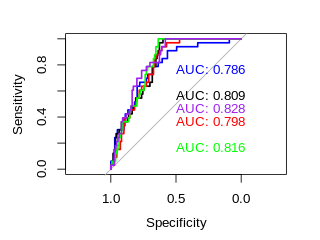

In [64]:
pdf('pred.SVM.pdf')
plot(roc(comp_pred$sledai, comp_pred$prediction), print.auc=TRUE, col = "blue", print.auc.y = .8)
plot(roc(ifn_pred$sledai, ifn_pred$prediction), print.auc=TRUE, add=T, col = "black", print.auc.y = .6)
plot(roc(pbmc_pred$sledai, pbmc_pred$prediction), print.auc=TRUE, add=T, col = "red", print.auc.y = .4)
plot(roc(pbmc_ct_pred$sledai, pbmc_ct_pred$prediction), print.auc=TRUE, add=T, col = "green", print.auc.y = .2)
plot(roc(ct_comp_pred$sledai, ct_comp_pred$prediction), print.auc=TRUE, add=T, col= "purple", print.auc.y = .5)
plot(roc(pbmc_var_pred$sledai, pbmc_var_pred$prediction), print.auc=TRUE, add=T, col = "pink", print.auc.y = .9)
plot(roc(ct_var_pred$sledai, ct_var_pred$prediction), print.auc=TRUE, add=T, col= "orange", print.auc.y = .1)
dev.off()

